# Effect of instantaneous weather sampling rate on subhourly clipping errors - SURFRAD-dra
These notebooks resample the SURFRAD network data at different frequencies to simulate satellite data.

In [1]:
import calendar
from dataclasses import dataclass
import pathlib
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pvlib
import rdtools
import seaborn as sns
from tqdm import tqdm

In [2]:
sns.set(font_scale=1.5, rc={'figure.figsize': (12, 8)})

In [3]:
# CONSTANTS
# https://gml.noaa.gov/grad/surfrad/sitepage.html
SURFRAD_TZ = {
    'bon': '-06:00', 'tbl': '-07:00', 'dra': '-08:00', 'fpk': '-07:00',
    'gwn': '-06:00', 'psu': '-05:00', 'sxf': '-06:00'}

## Some useful functions
* `read_surfrad_year` just reads all daily files from a yearly surfrad folder

In [4]:
def read_surfrad_year(surfrad_year_path):
    """
    Parameters
    -----------
    surfrad_year_path : pathlib.Path
        path to folder containing a single year of daily SURFRAD data files
    Returns
    -------
    df : pandas.DataFrame
        All of the daily weather data from folder of single year concatentated
        along time axis
    header : dict
        info about the location, timezone, and station name
    """
    data = [pvlib.iotools.read_surfrad(f) for f in surfrad_year_path.iterdir()]
    dfs, heads = zip(*data)
    df = pd.concat(dfs)
    header = heads[0]
    return df, header

## Accessing SURFRAD data
SURFRAD has 7 stations. pvlib-python has functions to download data from SURFRAD, but it takes a while, so I have previously downloaded and cached the data in folders for each station. Inside each station folder, there are folders for each year with data. Most stations began measurements in 1995 and continuously add new data one day at a time. These daily data files are stored in the yearly folders.

Here I specify the path the SURFRAD folder that contains all of the stations and then pick a single station to look at in this folder. Later we can try to manipulate all of the stations after working out the algorithms.

In [5]:
# specify path to all SURFRAD station data
surfrad_dir = pathlib.Path('../../SURFRAD')
print(f'Is there really a \33[1m\33[91m"SURFRAD"\33[0m\33[0m directory?'
      f' \33[1m\33[92m{surfrad_dir.exists()} \u2713\33[0m\33[0m')

Is there really a "SURFRAD" directory? True ✓


In [6]:
# specify path to just a single station, EG: Bondville, IL
weather_dir = "Desert_Rock_NV"
weather_path = surfrad_dir / weather_dir
print(f'Is there really a \33[1m\33[91m"{weather_path}"\33[0m\33[0m directory?'
      f' \33[1m\33[92m{weather_path.exists()} \u2713\33[0m\33[0m')

Is there really a "..\..\SURFRAD\Desert_Rock_NV" directory? True ✓


In [7]:
# display what years are in the SURFRAD station folder
weather_year_paths = weather_path.iterdir()
years = [p.parts[-1] for p in weather_year_paths]
', '.join(years)

'1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021'

## Narrowing Selection
There are a lot of years in a single station because SURFRAD has been operating for over 25 years! We can narrow our selection and make our work easier by checking:
* timestep or time-interval
* completeness of the year
* containing all of the required data

### Timesteps
SURFRAD stations collect data at either 3-minute or 1-minute intervals. For example, up until 2009, the Bondville, IL, station collected data at 3-minute intervals and then afterwards colected at 1-minute intervals. I narrow the selection by only using 1-minute intervals.

### Yearly Completeness
Each year has missing data, so I further narrow the selection by only using years that are at least 98% complete.

### Data Fields
Some of the fields are also missing. For example 1995 is missing all of the diffuse horizontal irradiance and about half of the air temperature data. I further narrow the selection by only using years with GHI, DHI, DNI, air temperature, wind speed, and solar zenith. This is a complete data set.

In [8]:
# how many years are missing data?
REQD_COLS = ['ghi', 'dhi', 'dni', 'solar_zenith', 'wind_speed', 'temp_air', 'pressure', 'relative_humidity']
weather_years = dict.fromkeys(years)
weather_stats = pd.DataFrame(index=years, columns=['Number of Records', 'Expected', 'Timestep', 'Completeness'])
for weather_year in tqdm(weather_path.iterdir()):
    weather_df, weather_header = read_surfrad_year(weather_year)
    year = weather_year.parts[-1]
    dt = np.diff(weather_df.index).min().seconds/60
    weather_years[year] = weather_df[REQD_COLS].dropna()
    num_recs = weather_years[year].shape[0]
    daze = 365*24*60/dt
    if calendar.isleap(int(year)):
        daze += (24*60/dt)
    frac_recs = num_recs/daze
    weather_stats.loc[year] = (num_recs, daze, dt, frac_recs)
weather_stats

24it [06:18, 15.77s/it]


,Number of Records,Expected,Timestep,Completeness
1998,136650,175200.0,3.0,0.779966
1999,172832,175200.0,3.0,0.986484
2000,168733,175680.0,3.0,0.960457
2001,172622,175200.0,3.0,0.985285
2002,162274,175200.0,3.0,0.926221
2003,174723,175200.0,3.0,0.997277
2004,175411,175680.0,3.0,0.998469
2005,166215,175200.0,3.0,0.948716
2006,173498,175200.0,3.0,0.990285
2007,174713,175200.0,3.0,0.99722


In [9]:
weather_header

{'name': 'Desert Rock',
 'latitude': 36.624,
 'longitude': -116.019,
 'elevation': 1007.0,
 'surfrad_version': 1,
 'tz': 'UTC'}

In [10]:
weather_df.columns

Index(['year', 'jday', 'month', 'day', 'hour', 'minute', 'dt', 'solar_zenith',
       'ghi', 'ghi_flag', 'uw_solar', 'uw_solar_flag', 'dni', 'dni_flag',
       'dhi', 'dhi_flag', 'dw_ir', 'dw_ir_flag', 'dw_casetemp',
       'dw_casetemp_flag', 'dw_dometemp', 'dw_dometemp_flag', 'uw_ir',
       'uw_ir_flag', 'uw_casetemp', 'uw_casetemp_flag', 'uw_dometemp',
       'uw_dometemp_flag', 'uvb', 'uvb_flag', 'par', 'par_flag', 'netsolar',
       'netsolar_flag', 'netir', 'netir_flag', 'totalnet', 'totalnet_flag',
       'temp_air', 'temp_air_flag', 'relative_humidity',
       'relative_humidity_flag', 'wind_speed', 'wind_speed_flag',
       'wind_direction', 'wind_direction_flag', 'pressure', 'pressure_flag'],
      dtype='object')

## QA/QC
Selecting only years that are > 98% complete and have 1-minute timestep, we reduce the number of years to 8: from 2010-2015, 2017, 2019

In [11]:
is_dt_1min = (weather_stats['Timestep'].values.astype(int) == 1)
is_98pct_complete = (weather_stats['Completeness'].values >= 0.98)
selected_years = weather_stats[is_dt_1min & is_98pct_complete]
selected_years

,Number of Records,Expected,Timestep,Completeness
2011,523365,525600.0,1.0,0.995748
2012,523528,527040.0,1.0,0.993336
2013,524864,525600.0,1.0,0.9986
2015,518470,525600.0,1.0,0.986435
2016,516712,527040.0,1.0,0.980404
2017,521358,525600.0,1.0,0.991929
2018,524590,525600.0,1.0,0.998078
2019,524043,525600.0,1.0,0.997038
2020,522471,527040.0,1.0,0.991331


In [12]:
# pop the unselected years from weather_years
for year in years:
    if year not in selected_years.index:
        print(f'{year}: {weather_stats.loc[year, "Completeness"]} complete and {weather_stats.loc[year, "Timestep"]}-min timestep')
        weather_years.pop(year)
list(weather_years.keys())

1998: 0.7799657534246576 complete and 3.0-min timestep
1999: 0.9864840182648402 complete and 3.0-min timestep
2000: 0.9604565118397086 complete and 3.0-min timestep
2001: 0.9852853881278539 complete and 3.0-min timestep
2002: 0.9262214611872146 complete and 3.0-min timestep
2003: 0.997277397260274 complete and 3.0-min timestep
2004: 0.9984688069216757 complete and 3.0-min timestep
2005: 0.9487157534246575 complete and 3.0-min timestep
2006: 0.9902853881278538 complete and 3.0-min timestep
2007: 0.9972203196347031 complete and 3.0-min timestep
2008: 0.9828324225865209 complete and 3.0-min timestep
2009: 0.9780422374429224 complete and 1.0-min timestep
2010: 0.8914878234398782 complete and 1.0-min timestep
2014: 0.9798915525114156 complete and 1.0-min timestep
2021: 0.07642884322678843 complete and 1.0-min timestep


['2011', '2012', '2013', '2015', '2016', '2017', '2018', '2019', '2020']

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:19<00:00,  2.17s/it]


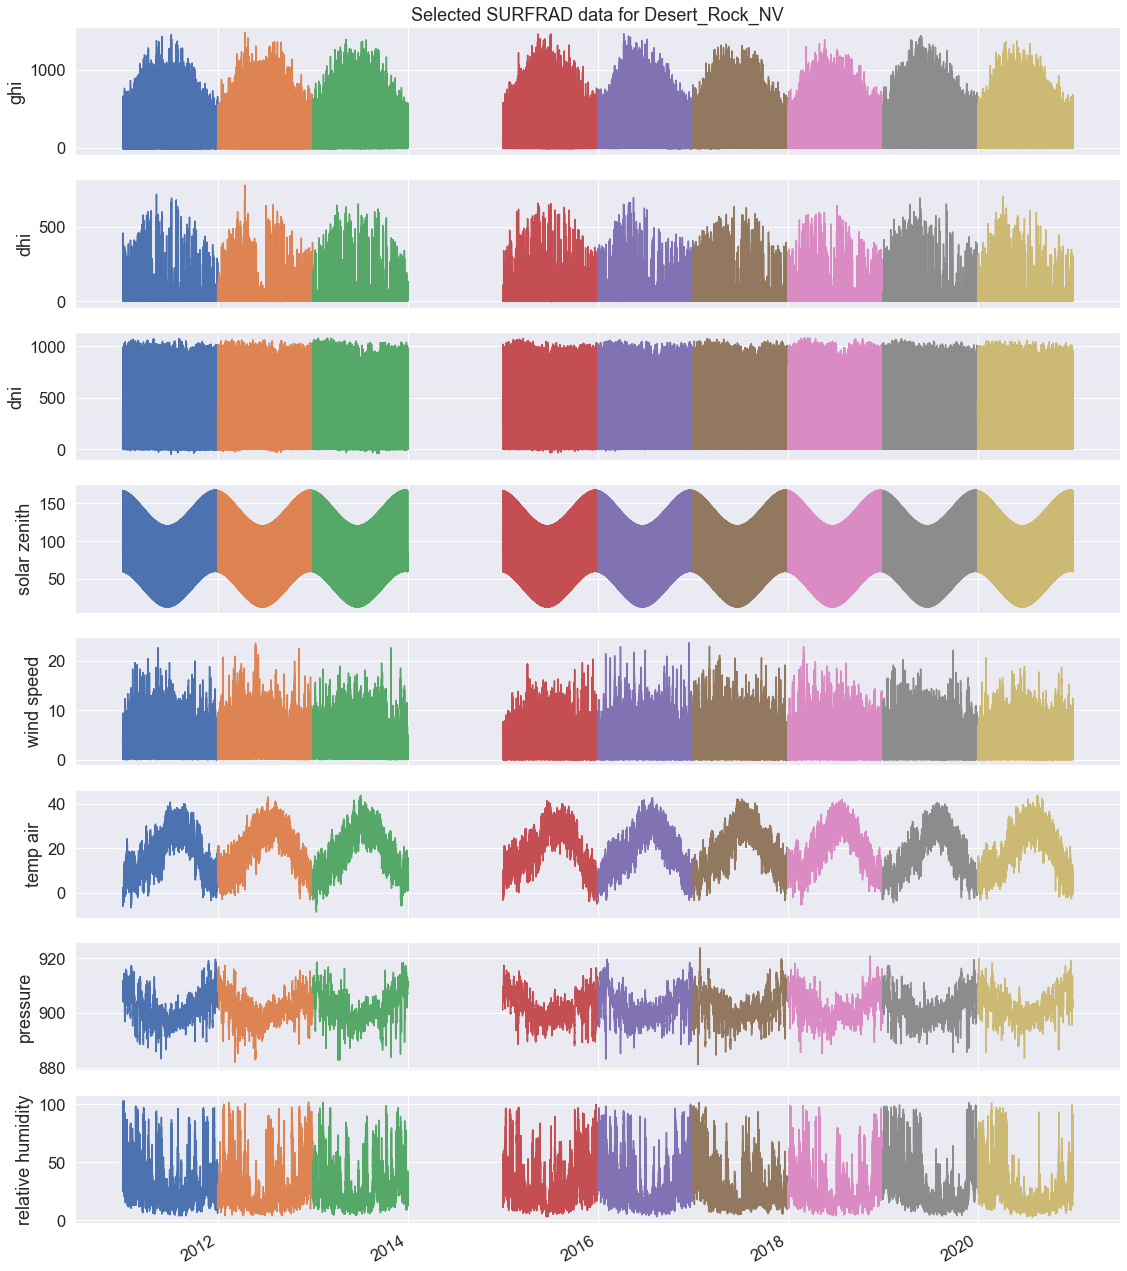

In [13]:
f, ax = plt.subplots(len(REQD_COLS), 1, sharex=True, figsize=(16, 18))
for n, k in enumerate(REQD_COLS):
    for year in tqdm(selected_years.index):
        #print(f'making plot of {k} for {year}')
        weather_years[year][k].plot(ax=ax[n])
    ax[n].set_ylabel(k.replace('_', ' '))
ax[0].set_title(f'Selected SURFRAD data for {weather_dir}')
f.tight_layout()

In [14]:
LATITUDE = weather_header['latitude']
LONGITUDE = weather_header['longitude']
ELEVATION = weather_header['elevation']
YEAR = selected_years.index[0]
print(f'year: {YEAR}')
TIMES = weather_years[YEAR].index

year: 2011


In [15]:
TIMES

DatetimeIndex(['2011-01-01 00:00:00+00:00', '2011-01-01 00:01:00+00:00',
               '2011-01-01 00:02:00+00:00', '2011-01-01 00:03:00+00:00',
               '2011-01-01 00:04:00+00:00', '2011-01-01 00:05:00+00:00',
               '2011-01-01 00:06:00+00:00', '2011-01-01 00:07:00+00:00',
               '2011-01-01 00:08:00+00:00', '2011-01-01 00:09:00+00:00',
               ...
               '2011-12-31 23:50:00+00:00', '2011-12-31 23:51:00+00:00',
               '2011-12-31 23:52:00+00:00', '2011-12-31 23:53:00+00:00',
               '2011-12-31 23:54:00+00:00', '2011-12-31 23:55:00+00:00',
               '2011-12-31 23:56:00+00:00', '2011-12-31 23:57:00+00:00',
               '2011-12-31 23:58:00+00:00', '2011-12-31 23:59:00+00:00'],
              dtype='datetime64[ns, UTC]', length=523365, freq=None)

In [16]:
df = weather_years[YEAR]
df.head()

,ghi,dhi,dni,solar_zenith,wind_speed,temp_air,pressure,relative_humidity
2011-01-01 00:00:00+00:00,29.6,21.5,190.0,84.06,4.5,-0.9,904.3,24.7
2011-01-01 00:01:00+00:00,34.4,21.4,257.8,84.22,4.0,-0.9,904.3,25.7
2011-01-01 00:02:00+00:00,38.9,21.2,330.9,84.38,4.6,-0.9,904.3,25.3
2011-01-01 00:03:00+00:00,41.6,20.8,383.0,84.54,4.5,-0.9,904.3,25.1
2011-01-01 00:04:00+00:00,38.7,20.3,370.4,84.70,3.8,-0.9,904.3,25.7


In [17]:
# get solar position
sp = pvlib.solarposition.get_solarposition(
        TIMES, LATITUDE, LONGITUDE)
solar_zenith = sp.apparent_zenith.values
solar_azimuth = sp.azimuth.values

In [18]:
# check the calculated zenith from SURFRAD
ze_mbe = 100 * (
    sum(solar_zenith - df.solar_zenith.values)
    / sum(df.solar_zenith.values))
print(f'zenith MBE: {ze_mbe}%')

zenith MBE: 0.002634881162074859%


## Load SURFRAD daily weather data
Each day is in a separate file. We already read this in using pvlib

In [19]:
# how many days are in this file
weather_year_paths = list(weather_path.iterdir())
year_idx = weather_year_paths.index(weather_path / YEAR)
weather_year_day_files = list(weather_year_paths[year_idx].iterdir())
CODENAME = weather_year_day_files[0].stem[:3]
TZ = SURFRAD_TZ[CODENAME]
print(f'{CODENAME} timezone: {TZ}')
day_files = {int(d.parts[-1][5:-4]) for d in weather_year_day_files}
len(day_files)

dra timezone: -08:00


365

In [20]:
# missing days
missing_days = set(range(1, 366)) - day_files
missing_days

set()

## Sanity check
Look at a few timestamps around solar noon and display only a handful of columns:
* direct normal irradiance (DNI): `'dni'`
* global horizontal irradiance (GHI): `'ghi'`
* diffuse horizontal irradiance (DHI): `'dhi'`
* solar zenith: `'solar_zenith'`
* wind speed: `'wind_speed'`
* air temperature: `'temp_air'`

In [21]:
# view a few timestamps to sanity check (E. Tufte, ...)
df[f'{YEAR}-07-07T12:09:00{TZ}':f'{YEAR}-07-07T12:18:00{TZ}'][REQD_COLS]  # <-- XXX: pick dates for each month

,ghi,dhi,dni,solar_zenith,wind_speed,temp_air,pressure,relative_humidity
2011-07-07 20:09:00+00:00,789.8,617.4,174.5,14.69,0.9,31.8,901.0,34.0
2011-07-07 20:10:00+00:00,773.8,612.5,183.6,14.75,2.0,31.9,901.0,32.9
2011-07-07 20:11:00+00:00,711.5,609.0,94.0,14.82,3.2,31.9,901.0,32.3
2011-07-07 20:12:00+00:00,642.6,613.2,29.8,14.89,4.3,31.7,901.0,32.3
2011-07-07 20:13:00+00:00,688.0,621.6,62.4,14.96,3.4,31.5,900.9,32.4
2011-07-07 20:14:00+00:00,725.1,630.3,83.1,15.03,3.5,31.3,900.9,32.5
2011-07-07 20:15:00+00:00,894.1,643.9,254.7,15.11,2.6,31.2,900.9,32.6
2011-07-07 20:16:00+00:00,918.8,662.1,269.7,15.19,2.5,31.3,900.8,32.7
2011-07-07 20:17:00+00:00,1320.4,684.9,668.7,15.27,0.8,31.4,900.8,32.3
2011-07-07 20:18:00+00:00,1155.4,694.9,478.4,15.36,1.2,31.8,900.8,32.0


In [22]:
JULY7_MORN, JULY7_NITE = f'{YEAR}-07-07T04:00:00{TZ}', f'{YEAR}-07-07T20:00:00{TZ}'
JAN7_MORN, JAN7_NITE = f'{YEAR}-01-07T06:00:00{TZ}', f'{YEAR}-01-07T18:00:00{TZ}'

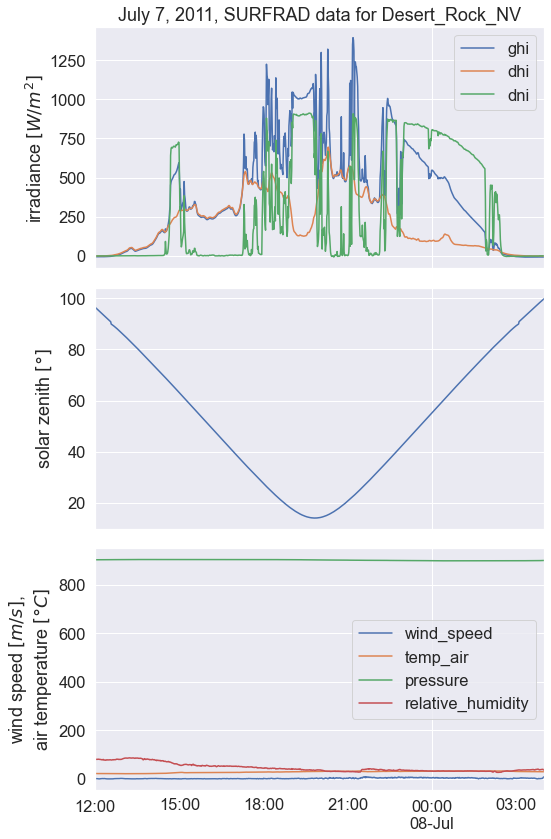

In [23]:
f, ax = plt.subplots(3, 1, sharex=True, figsize=(8, 12))
df[JULY7_MORN:JULY7_NITE][REQD_COLS[:3]].plot(ax=ax[0])
ax[0].set_title(f'July 7, {YEAR}, SURFRAD data for {weather_dir}')
ax[0].set_ylabel('irradiance $[W/m^2]$')
df[JULY7_MORN:JULY7_NITE][REQD_COLS[3]].plot(ax=ax[1])
ax[1].set_ylabel('solar zenith $[\degree]$')
df[JULY7_MORN:JULY7_NITE][REQD_COLS[4:]].plot(ax=ax[2])
ax[2].set_ylabel('wind speed $[m/s]$,\nair temperature $[\degree C]$')
f.tight_layout()

## Data quality
Do some basic quality checking:
1. no irradiance should be negative
2. the DHI has to be the same as
    $$GHI - DNI \cos \left( \theta \right)$$

Then plot a sample day and take a look:

In [24]:
dni = np.maximum(0, df['dni'])
ghi = np.maximum(0, df['ghi'])
dhi = np.maximum(0, df['dhi'])
zerad = np.radians(df['solar_zenith'])
dhi_calc = pd.Series(np.maximum(0, ghi - dni*np.cos(zerad)), name='DHI calc')
irr_check = pd.concat([dni, ghi, dhi, dhi_calc], axis=1)

In [25]:
# check the calculated zenith from SURFRAD
dhi_mbe = 100 * (
    sum(dhi.resample('D').sum() - dhi_calc.resample('D').sum())
    / sum(dhi.resample('D').sum()))
print(f'dhi MBE: {dhi_mbe}%')

dhi MBE: 10.01535209110014%


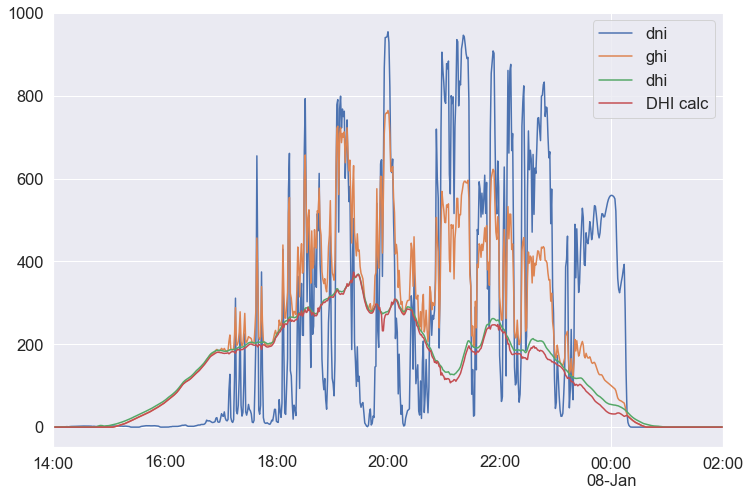

In [26]:
irr_check[JAN7_MORN:JAN7_NITE].plot()  # <-- XXX: pick dates for each month
plt.legend()

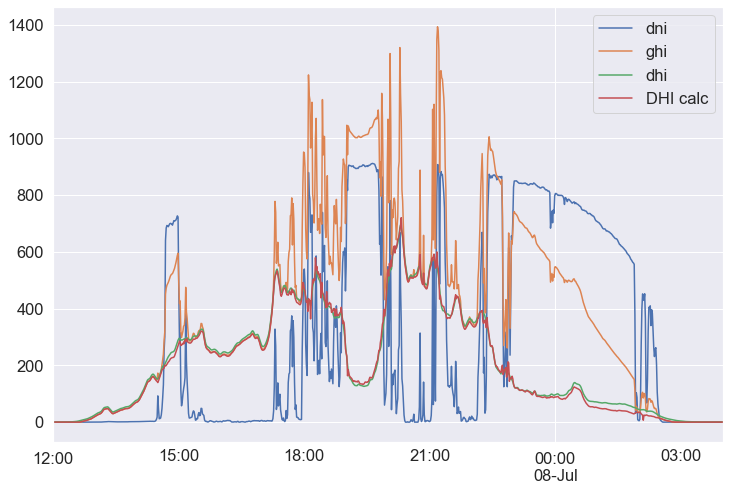

In [27]:
irr_check[JULY7_MORN:JULY7_NITE].plot()  # <-- XXX: pick dates for each month
plt.legend()

## assembling weather file
To model the output we need the following columns:
1. datetime as ISO8601 but no nanoseconds or timezone
2. GHI
2. DHI
3. Temp
4. WS

In [28]:
# get other parameters needed for modeling like windspeed and air temp
wspd = df['wind_speed']
tair = df['temp_air']

In [29]:
weather = pd.concat([ghi, dni, dhi, tair, wspd], axis=1)
weather.index.name = 'datetime'
weather.columns = ['GHI', 'DNI', 'DHI', 'Temp', 'WS']
weather.head()

,GHI,DNI,DHI,Temp,WS
datetime,,,,,
2011-01-01 00:00:00+00:00,29.6,190.0,21.5,-0.9,4.5
2011-01-01 00:01:00+00:00,34.4,257.8,21.4,-0.9,4.0
2011-01-01 00:02:00+00:00,38.9,330.9,21.2,-0.9,4.6
2011-01-01 00:03:00+00:00,41.6,383.0,20.8,-0.9,4.5
2011-01-01 00:04:00+00:00,38.7,370.4,20.3,-0.9,3.8


In [30]:
weather.loc[f'{YEAR}-01-01T08:21:00{TZ}']  # <-- XXX: pick dates for each month

GHI     146.9
DNI     481.1
DHI      52.9
Temp     -3.6
WS        1.5
Name: 2011-01-01 16:21:00+00:00, dtype: float64

## Simulate 5-minute sampled satellite data
Choose instantaneous records every five minutes. Choose approximately the middle of the 5-minute sampling interval. Since these are 1-minute timestamps already, the closest to the middle is either the 2nd or 3rd minute.

In [31]:
weather5inst = weather.resample('5T').first()
weather5inst60min = weather5inst.resample('H').mean()
weather5inst60min[JAN7_MORN:JAN7_NITE]

,GHI,DNI,DHI,Temp,WS
datetime,,,,,
2011-01-07 14:00:00+00:00,0.000000,1.391667,0.575000,3.108333,1.008333
2011-01-07 15:00:00+00:00,21.458333,2.000000,27.050000,4.841667,2.441667
2011-01-07 16:00:00+00:00,119.958333,6.275000,123.500000,5.208333,1.408333
2011-01-07 17:00:00+00:00,225.033333,94.475000,196.066667,6.241667,1.783333
2011-01-07 18:00:00+00:00,366.083333,205.575000,272.008333,8.650000,3.216667
2011-01-07 19:00:00+00:00,472.258333,313.266667,319.325000,9.850000,4.258333
2011-01-07 20:00:00+00:00,380.533333,276.116667,246.633333,10.375000,4.591667
2011-01-07 21:00:00+00:00,471.258333,660.000000,186.708333,12.341667,1.650000
2011-01-07 22:00:00+00:00,376.000000,549.041667,203.775000,12.491667,1.491667


## Ditto for every 15-minutes
Repeat for 15 minute intervals. Same dilemma, the closest record to the middle of the interval is either the 7th or 8th minute.

In [32]:
weather15inst = weather.resample('15T').first()
weather15inst60min = weather15inst.resample('H').mean()
weather15inst60min[JAN7_MORN:JAN7_NITE]

,GHI,DNI,DHI,Temp,WS
datetime,,,,,
2011-01-07 14:00:00+00:00,0.000,1.350,0.150,3.125,0.950
2011-01-07 15:00:00+00:00,16.925,1.925,22.250,4.675,2.500
2011-01-07 16:00:00+00:00,108.600,5.275,112.300,4.925,1.375
2011-01-07 17:00:00+00:00,220.675,84.375,195.175,6.100,1.775
2011-01-07 18:00:00+00:00,414.600,323.025,262.225,8.475,3.350
2011-01-07 19:00:00+00:00,433.725,219.100,325.575,9.825,4.475
2011-01-07 20:00:00+00:00,429.325,356.600,253.975,10.250,4.625
2011-01-07 21:00:00+00:00,435.950,589.300,177.325,12.100,1.475
2011-01-07 22:00:00+00:00,363.525,499.025,209.075,12.550,1.350


## Ditto 30-minutes

In [33]:
weather30inst = weather.resample('30T').first()
weather30inst60min = weather30inst.resample('H').mean()
weather30inst60min[JAN7_MORN:JAN7_NITE]

,GHI,DNI,DHI,Temp,WS
datetime,,,,,
2011-01-07 14:00:00+00:00,0.00,1.25,0.00,2.75,1.30
2011-01-07 15:00:00+00:00,11.10,1.25,15.80,3.80,2.50
2011-01-07 16:00:00+00:00,90.70,1.00,95.65,4.60,1.85
2011-01-07 17:00:00+00:00,202.60,38.20,194.25,6.20,1.25
2011-01-07 18:00:00+00:00,408.65,340.75,252.30,8.05,2.10
2011-01-07 19:00:00+00:00,380.20,88.60,338.30,9.85,4.30
2011-01-07 20:00:00+00:00,537.55,529.55,270.85,10.30,4.25
2011-01-07 21:00:00+00:00,372.00,455.50,167.30,11.95,1.90
2011-01-07 22:00:00+00:00,337.00,371.75,220.70,12.50,1.80


## Ditto 60-minutes

In [34]:
weather60inst = weather.resample('H').first()
weather60inst[JAN7_MORN:JAN7_NITE]

,GHI,DNI,DHI,Temp,WS
datetime,,,,,
2011-01-07 14:00:00+00:00,0.0,0.0,0.0,2.5,2.4
2011-01-07 15:00:00+00:00,0.0,2.5,3.7,4.3,2.8
2011-01-07 16:00:00+00:00,59.4,0.0,64.7,4.3,1.3
2011-01-07 17:00:00+00:00,186.6,21.6,185.3,5.9,1.4
2011-01-07 18:00:00+00:00,224.0,14.0,222.2,6.9,1.0
2011-01-07 19:00:00+00:00,372.6,117.9,317.4,9.5,4.4
2011-01-07 20:00:00+00:00,764.3,954.3,279.3,10.1,4.5
2011-01-07 21:00:00+00:00,523.8,831.4,136.5,11.4,2.2
2011-01-07 22:00:00+00:00,314.0,173.1,252.8,12.9,2.1


# Visual Comparison of different sampling intervals
How do these look compared to each other? Are they shifted correctly? Are they on the same order? Do they capture the variability?

Text(0, 0.5, 'GHI $[W/m^2]$')

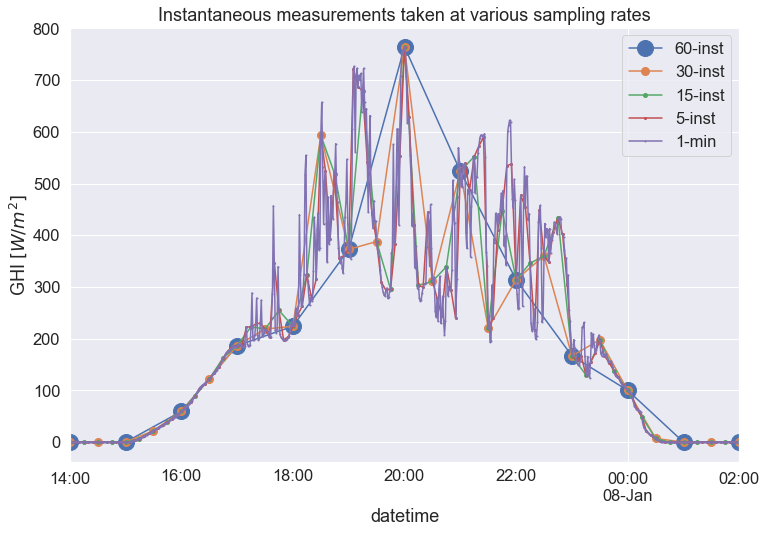

In [35]:
ax = weather60inst[JAN7_MORN:JAN7_NITE]['GHI'].plot(marker='o', ms=16)
weather30inst[JAN7_MORN:JAN7_NITE]['GHI'].plot(ax=ax, marker='o', ms=8)
weather15inst[JAN7_MORN:JAN7_NITE]['GHI'].plot(ax=ax, marker='o', ms=4)
weather5inst[JAN7_MORN:JAN7_NITE]['GHI'].plot(ax=ax, marker='o', ms=2)
weather[JAN7_MORN:JAN7_NITE]['GHI'].plot(ax=ax, marker='o', ms=1)
plt.legend(['60-inst', '30-inst', '15-inst', '5-inst', '1-min'])
plt.title('Instantaneous measurements taken at various sampling rates')
plt.ylabel('GHI $[W/m^2]$')

Text(0, 0.5, 'GHI $[W/m^2]$')

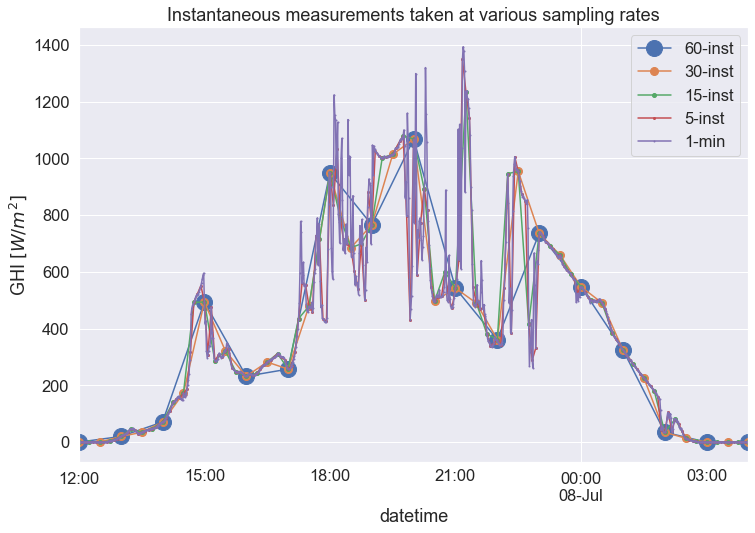

In [36]:
ax = weather60inst[JULY7_MORN:JULY7_NITE]['GHI'].plot(marker='o', ms=16)
weather30inst[JULY7_MORN:JULY7_NITE]['GHI'].plot(ax=ax, marker='o', ms=8)
weather15inst[JULY7_MORN:JULY7_NITE]['GHI'].plot(ax=ax, marker='o', ms=4)
weather5inst[JULY7_MORN:JULY7_NITE]['GHI'].plot(ax=ax, marker='o', ms=2)
weather[JULY7_MORN:JULY7_NITE]['GHI'].plot(ax=ax, marker='o', ms=1)
plt.legend(['60-inst', '30-inst', '15-inst', '5-inst', '1-min'])
plt.title('Instantaneous measurements taken at various sampling rates')
plt.ylabel('GHI $[W/m^2]$')

## Hourly averages from instantaneously sampled

Text(0, 0.5, 'GHI $[W/m^2]$')

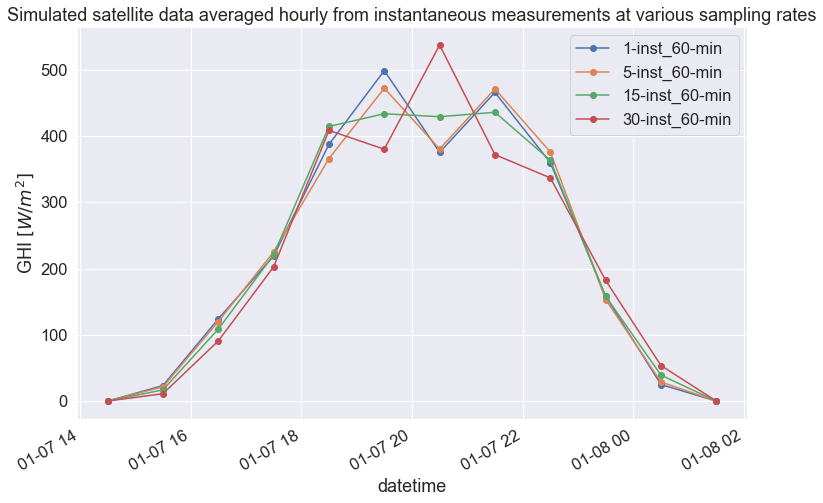

In [37]:
ax = weather.resample('H').mean().shift(freq='30min')[JAN7_MORN:JAN7_NITE]['GHI'].plot(marker='o')
weather5inst60min.shift(freq='30min')[JAN7_MORN:JAN7_NITE]['GHI'].plot(ax=ax, marker='o')
weather15inst60min.shift(freq='30min')[JAN7_MORN:JAN7_NITE]['GHI'].plot(ax=ax, marker='o')
weather30inst60min.shift(freq='30min')[JAN7_MORN:JAN7_NITE]['GHI'].plot(ax=ax, marker='o')
plt.legend(['1-inst_60-min', '5-inst_60-min', '15-inst_60-min', '30-inst_60-min'])
plt.title('Simulated satellite data averaged hourly from instantaneous measurements at various sampling rates')
plt.ylabel('GHI $[W/m^2]$')

Text(0, 0.5, 'GHI $[W/m^2]$')

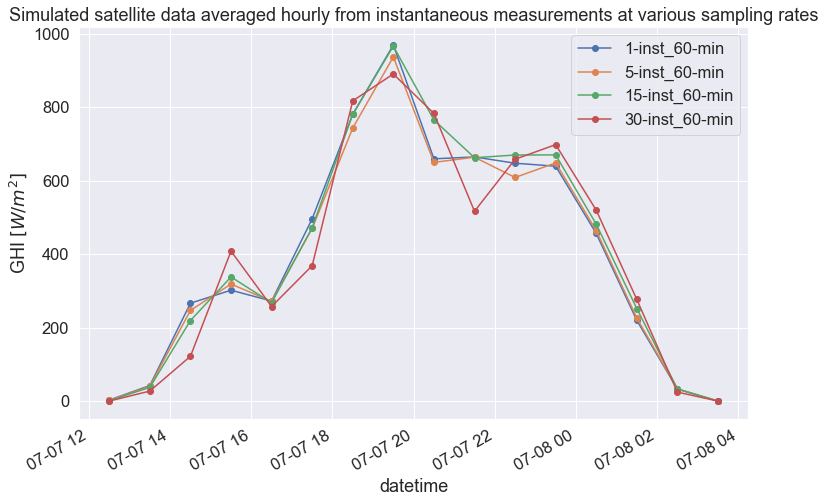

In [38]:
ax = weather.resample('H').mean().shift(freq='30min')[JULY7_MORN:JULY7_NITE]['GHI'].plot(marker='o')
weather5inst60min.shift(freq='30min')[JULY7_MORN:JULY7_NITE]['GHI'].plot(ax=ax, marker='o')
weather15inst60min.shift(freq='30min')[JULY7_MORN:JULY7_NITE]['GHI'].plot(ax=ax, marker='o')
weather30inst60min.shift(freq='30min')[JULY7_MORN:JULY7_NITE]['GHI'].plot(ax=ax, marker='o')
plt.legend(['1-inst_60-min', '5-inst_60-min', '15-inst_60-min', '30-inst_60-min'])
plt.title('Simulated satellite data averaged hourly from instantaneous measurements at various sampling rates')
plt.ylabel('GHI $[W/m^2]$')

In [39]:
weather.resample('H').mean()[JAN7_MORN:JAN7_NITE]

,GHI,DNI,DHI,Temp,WS
datetime,,,,,
2011-01-07 14:00:00+00:00,0.000000,1.425000,0.686667,3.140000,1.073333
2011-01-07 15:00:00+00:00,23.396667,1.923333,29.056667,4.843333,2.520000
2011-01-07 16:00:00+00:00,123.943333,5.985000,127.556667,5.261667,1.513333
2011-01-07 17:00:00+00:00,218.965000,74.006667,197.026667,6.278333,1.765000
2011-01-07 18:00:00+00:00,387.436667,247.095000,275.220000,8.715000,3.216667
2011-01-07 19:00:00+00:00,498.901667,363.473333,317.958333,9.855000,4.301667
2011-01-07 20:00:00+00:00,375.500000,278.396667,241.811667,10.413333,4.543333
2011-01-07 21:00:00+00:00,465.893333,644.063333,190.371667,12.368333,1.541667
2011-01-07 22:00:00+00:00,359.985000,518.723333,200.648333,12.463333,1.751667


## Compare 15-minute time averaged to 15-minute instantaneous
How do shorter sampling intervals compare to time averaged values? Starting with 1-minute data, average every 15-minutes and compare to picking a single instantaneous record every 15 minutes, starting at the 7th minute.

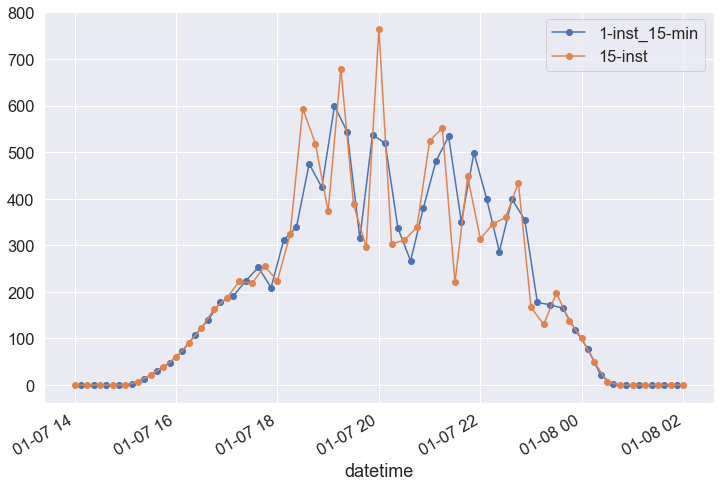

In [40]:
ax = weather.resample('15T').mean().shift(freq='450s')[JAN7_MORN:JAN7_NITE]['GHI'].plot(marker='o')
weather15inst[JAN7_MORN:JAN7_NITE]['GHI'].plot(ax=ax, marker='o')
plt.legend(['1-inst_15-min', '15-inst'])

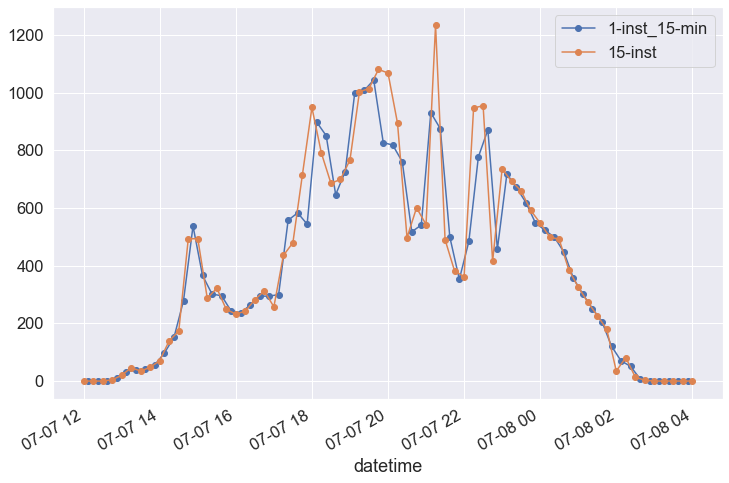

In [41]:
ax = weather.resample('15T').mean().shift(freq='450s')[JULY7_MORN:JULY7_NITE]['GHI'].plot(marker='o')
weather15inst[JULY7_MORN:JULY7_NITE]['GHI'].plot(ax=ax, marker='o')
plt.legend(['1-inst_15-min', '15-inst'])

In [42]:
weather.resample('15T').mean()[f'{YEAR}-07-07T11:00:00{TZ}':f'{YEAR}-07-07T13:00:00{TZ}']

,GHI,DNI,DHI,Temp,WS
datetime,,,,,
2011-07-07 19:00:00+00:00,997.780000,868.553333,161.226667,29.800000,1.920000
2011-07-07 19:15:00+00:00,1007.460000,900.920000,128.946667,30.193333,1.333333
2011-07-07 19:30:00+00:00,1043.733333,904.860000,157.020000,30.740000,1.920000
2011-07-07 19:45:00+00:00,826.806667,501.066667,322.893333,30.793333,2.420000
2011-07-07 20:00:00+00:00,817.933333,239.466667,574.613333,31.280000,2.580000
2011-07-07 20:15:00+00:00,760.613333,160.493333,608.486667,31.673333,3.346667
2011-07-07 20:30:00+00:00,517.553333,4.406667,520.986667,31.460000,3.700000
2011-07-07 20:45:00+00:00,540.846667,40.593333,507.226667,31.633333,2.566667
2011-07-07 21:00:00+00:00,930.380000,409.553333,547.933333,31.626667,3.353333


# Time Averaged
This is the original clipping error problem.

In [43]:
# timestamps are at the beginning of the interval
weather5min = weather.resample('5T').mean()
weather15min = weather.resample('15T').mean()
weather30min = weather.resample('30T').mean()
weather60min = weather.resample('H').mean()

# Run Model
Now we _finally_ have all the files for 2010 that we need, we can finally run the model and calculate the clipping errors. We'll come back and run it for other years and other sites once we get it working.

In [44]:
# use 250kWac typical central inverter
INVERTERS = pvlib.pvsystem.retrieve_sam('CECInverter')
INVERTER_250K = INVERTERS['SMA_America__SC250U__480V_']
INVERTER_250K

Vac                          480
Pso                  2064.528564
Paco                    250000.0
Pdco               259022.859375
Vdco                       370.0
C0                          -0.0
C1                      0.000005
C2                      0.001166
C3                     -0.000893
Pnt                         75.0
Vdcmax                     480.0
Idcmax                700.061782
Mppt_low                   330.0
Mppt_high                  480.0
CEC_Date               4/16/2018
CEC_Type     Utility Interactive
Name: SMA_America__SC250U__480V_, dtype: object

In [45]:
# choose typical front-contact silicon modules
CECMODS = pvlib.pvsystem.retrieve_sam('CECMod')
# for now, for simplicity, just one mono-silicon module, mono
CECMOD_MONO = CECMODS['Canadian_Solar_Inc__CS6X_300M']
CECMOD_MONO

Technology            Mono-c-Si
Bifacial                      0
STC                      300.03
PTC                       273.6
A_c                       1.852
Length                    1.931
Width                     0.959
N_s                          72
I_sc_ref                   8.74
V_oc_ref                   45.0
I_mp_ref                   8.22
V_mp_ref                   36.5
alpha_sc               0.004326
beta_oc                -0.15372
T_NOCT                     44.3
a_ref                  1.861184
I_L_ref                8.745869
I_o_ref                     0.0
R_s                    0.366101
R_sh_ref             545.178589
Adjust                 4.722239
gamma_r                  -0.442
BIPV                          N
Version       SAM 2018.11.11 r2
Date                   1/3/2019
Name: Canadian_Solar_Inc__CS6X_300M, dtype: object

In [46]:
# tracker positions
tracker = pvlib.tracking.singleaxis(solar_zenith, solar_azimuth)
surface_tilt = tracker['surface_tilt']
surface_azimuth = tracker['surface_azimuth']

In [47]:
# calculate irradiance inputs
dni_extra = pvlib.irradiance.get_extra_radiation(TIMES).values

In [48]:
# irrad components in plane of array
poa_sky_diffuse = pvlib.irradiance.get_sky_diffuse(
        surface_tilt, surface_azimuth, solar_zenith, solar_azimuth,
        dni, ghi, dhi, dni_extra=dni_extra, model='haydavies')
aoi = tracker['aoi']
poa_ground_diffuse = pvlib.irradiance.get_ground_diffuse(
        surface_tilt, ghi)
poa = pvlib.irradiance.poa_components(
        aoi, dni, poa_sky_diffuse, poa_ground_diffuse)
poa_direct = poa['poa_direct']
poa_diffuse = poa['poa_diffuse']
poa_global = poa['poa_global']
iam = pvlib.iam.ashrae(aoi)
effective_irradiance = poa_direct*iam + poa_diffuse

In [49]:
# cell temperature with 10-minute rolling average
module_efficiency = CECMOD_MONO.STC / (CECMOD_MONO.A_c*1000)
temp_cell = pvlib.temperature.pvsyst_cell(
    poa_global, temp_air=tair, wind_speed=wspd, u_c=25.0, u_v=1.2,
    module_efficiency=module_efficiency).rolling('10T', center=True).mean()

<AxesSubplot:>

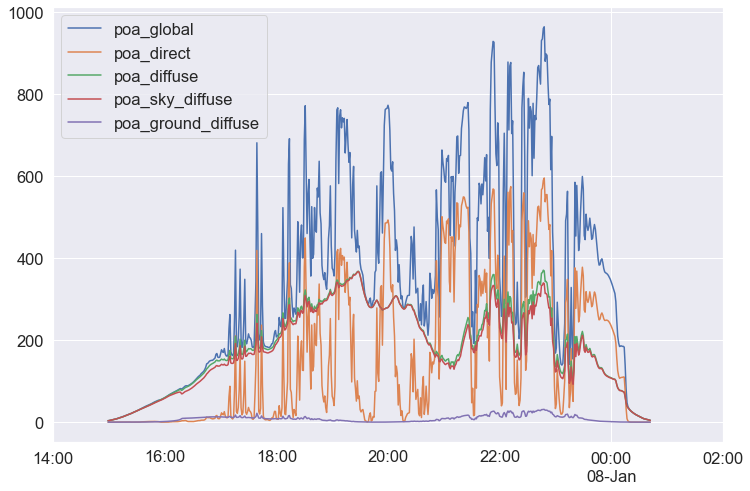

In [50]:
# the goods
poa[JAN7_MORN:JAN7_NITE].plot()

<AxesSubplot:>

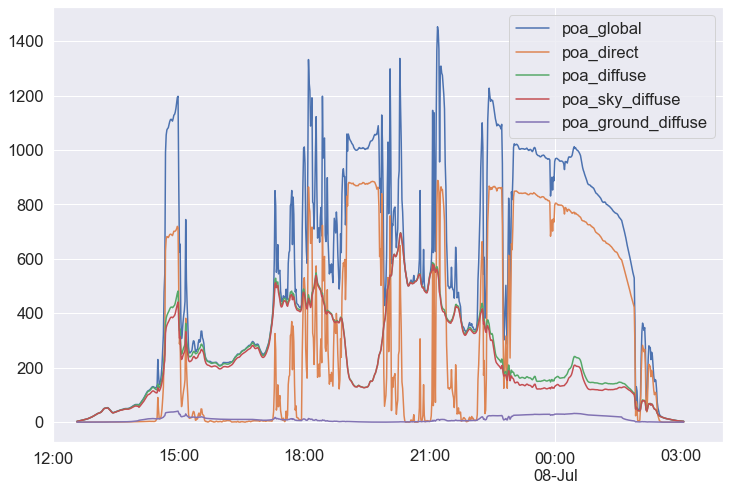

In [51]:
poa[JULY7_MORN:JULY7_NITE].plot()

In [52]:
# this is the magic
cecparams = pvlib.pvsystem.calcparams_cec(
        effective_irradiance, temp_cell,
        CECMOD_MONO.alpha_sc, CECMOD_MONO.a_ref,
        CECMOD_MONO.I_L_ref, CECMOD_MONO.I_o_ref,
        CECMOD_MONO.R_sh_ref, CECMOD_MONO.R_s, CECMOD_MONO.Adjust)
mpp = pvlib.pvsystem.max_power_point(*cecparams, method='newton')
mpp = pd.DataFrame(mpp, index=TIMES)

In [53]:
module_efficiency

0.16200323974082073

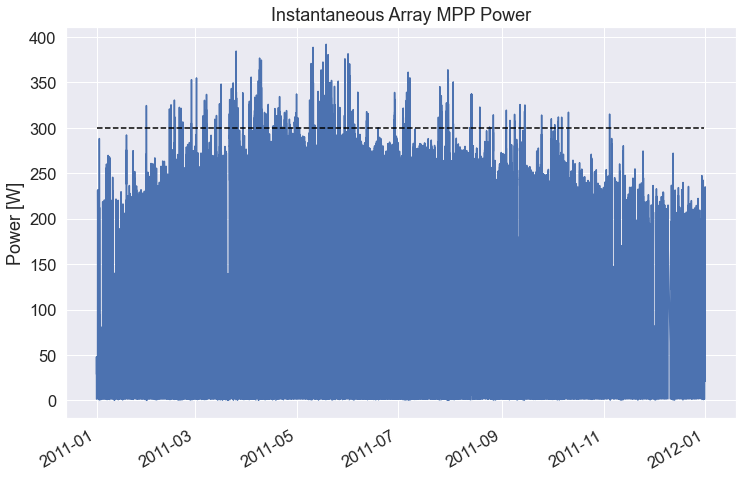

In [54]:
# the goods
mpp.p_mp.plot(title='Instantaneous Array MPP Power')
plt.hlines(xmin=f'{YEAR}-01-01', xmax=f'{YEAR}-12-31', y=CECMOD_MONO.STC, linestyles='--', colors='black')
plt.ylabel('Power [W]');

In [55]:
temp_ref = 25.0  # degC
dc_ac = 1.3
# maximum open circuit voltage
MAX_VOC = CECMOD_MONO.V_oc_ref + CECMOD_MONO.beta_oc * (tair.min() - temp_ref)
STRING_LENGTH = int(INVERTER_250K['Vdcmax'] // MAX_VOC)
STRING_VOLTAGE = STRING_LENGTH * MAX_VOC
STRING_OUTPUT = CECMOD_MONO.STC * STRING_LENGTH
STRING_COUNT = int(dc_ac * INVERTER_250K['Paco'] // STRING_OUTPUT)
DC_CAPACITY = STRING_COUNT * STRING_OUTPUT
DCAC = DC_CAPACITY / INVERTER_250K['Paco']
STRINGING_STATS = {
    'max Voc': MAX_VOC, 'string length': STRING_LENGTH, 'string voltage': STRING_VOLTAGE,
    'string output': STRING_OUTPUT, 'string count': STRING_COUNT, 'DC capacity': DC_CAPACITY,
    'DC/AC': DCAC}
STRINGING_STATS

{'max Voc': 49.888296,
 'string length': 9,
 'string voltage': 448.99466399999994,
 'string output': 2700.2699999999995,
 'string count': 120,
 'DC capacity': 324032.39999999997,
 'DC/AC': 1.2961295999999998}

In [56]:
DC_OUTPUT = mpp.p_mp * STRING_LENGTH * STRING_COUNT
AC_OUTPUT = pvlib.inverter.sandia(
    mpp.v_mp * STRING_LENGTH,
    mpp.p_mp * STRING_LENGTH * STRING_COUNT,
    INVERTER_250K)
AC_OUTPUT.max()

250000.0

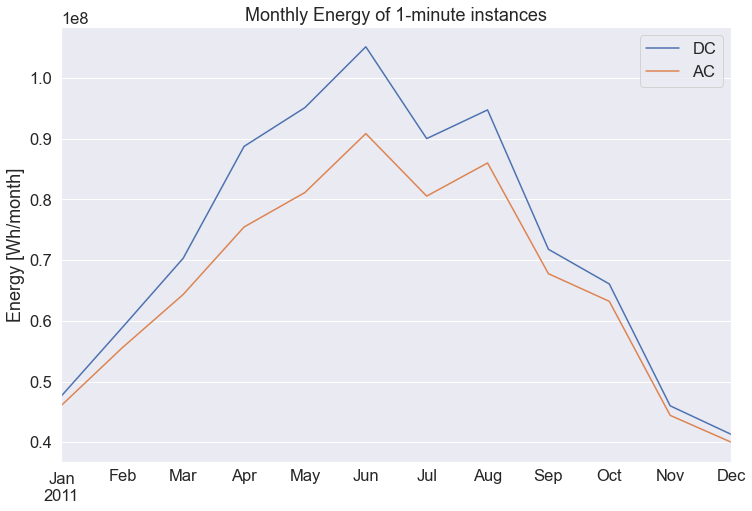

In [57]:
# the goods
EARRMPP = 1/60*DC_OUTPUT
EGRID = 1/60*AC_OUTPUT
ax = EARRMPP.resample('M').sum().plot(label='DC', title='Monthly Energy of 1-minute instances')
EGRID.resample('M').sum().plot(ax=ax, label='AC')
plt.ylabel('Energy [Wh/month]')
plt.legend()

In [58]:
print(f'1-minute instant annual DC & AC energy: {EARRMPP.sum()/1e6, EGRID.sum()/1e6} MWh')

1-minute instant annual DC & AC energy: (875.6254513680317, 795.296362666183) MWh


<AxesSubplot:>

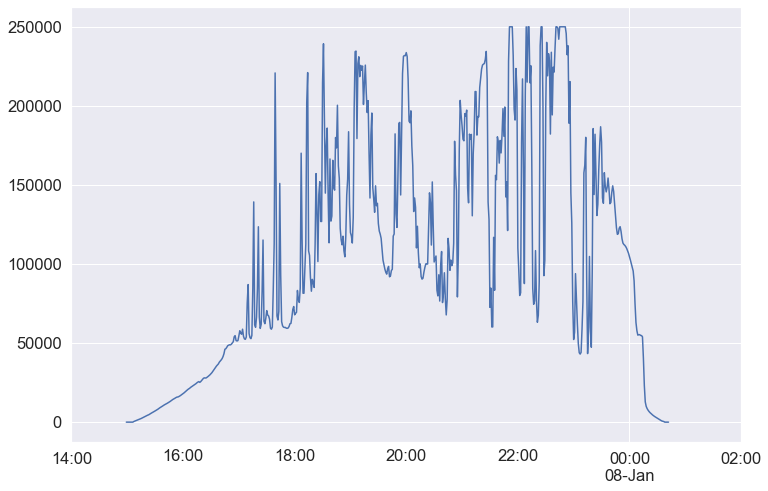

In [59]:
AC_OUTPUT[JAN7_MORN:JAN7_NITE].plot()

<AxesSubplot:>

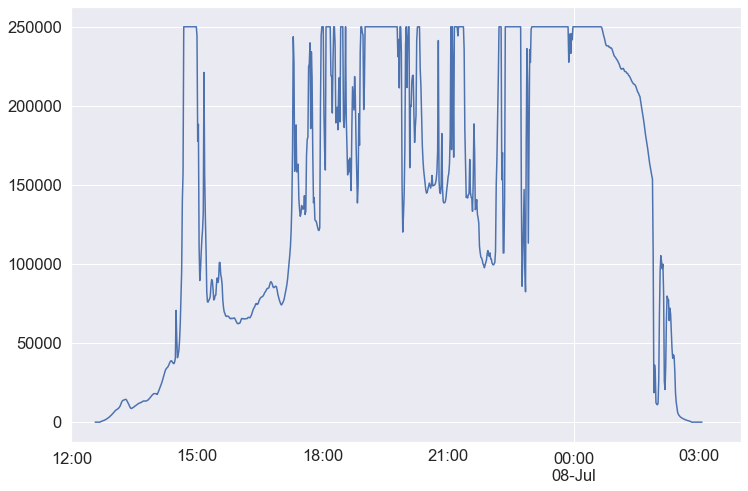

In [60]:
AC_OUTPUT[JULY7_MORN:JULY7_NITE].plot()

<AxesSubplot:>

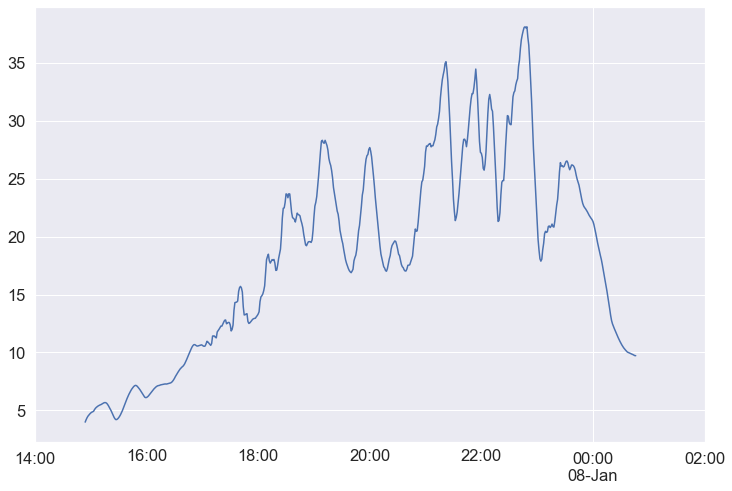

In [61]:
temp_cell[JAN7_MORN:JAN7_NITE].plot()

<AxesSubplot:>

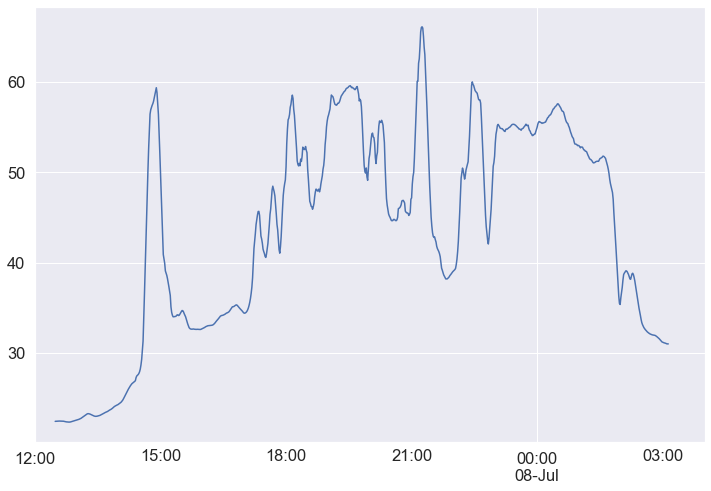

In [62]:
temp_cell[JULY7_MORN:JULY7_NITE].plot()

## More Convenient Functions
Create a function to automate the tasks above for all of datasets in the analysis.

### PV Model
This is a data class that just has the PV module and inverter parameters

### `calc_power()`
This is a function that outputs the instantaneous DC and AC power at each instant. Multiply output by the timestep in hours to get the energy.

### weather files
Now we use the convenience functions to loop over all 15 types of weather files.

#### instantaneous measurements
1. `weather`: 1-minute instantaneous
2. `weather5inst`: every 5th minute
3. `weather15inst`: every 15th minute
4. `weather30inst`: every 30th minute
5. `weather60inst`: once an hour

#### simulated satellite
instantaneous time-averaged to hourly
1. `weather60min`: 1-minute instances time-averaged to hourly
2. `weather5inst60min`: 5-minute instances time-average to hourly
3. `weather15inst60min`: 15-minute instances time-averaged to hourly
4. `weather30inst60min`: 30-minute instances time-averaged to hourly
5. `weather60inst`: once an hour

#### time-averaged
1. `weather`: 1-minute instantaneous
2. `weather5min`: 5-minute time-averaged
3. `weather15min`: 15-minute time-averaged
4. `weather30min`: 30-minute time-averaged
5. `weather60min`: 60-minute time-averaged

In [63]:
# some more convenient functions

@dataclass
class PVModel:
    latitude: float
    longitude: float
    elevation: float
    pvmodule : dict
    inverter : dict
    temp_ref: float = 25.0  # degC
    dc_ac: float = 1.3

    def string_array(self, tair) -> dict:
        # maximum open circuit voltage
        max_voc = self.pvmodule.V_oc_ref + self.pvmodule.beta_oc * (tair.min() - self.temp_ref)
        string_length = int(self.inverter['Vdcmax'] // max_voc)
        string_voltage = string_length * max_voc
        string_output = self.pvmodule.STC * string_length
        string_count = int(dc_ac * self.inverter['Paco'] // string_output)
        dc_capacity = string_count * string_output
        dc_ac_actual = dc_capacity / self.inverter['Paco']
        string_stats = {
            'max Voc': max_voc, 'string length': string_length, 'string voltage': string_voltage,
            'string output': string_output, 'string count': string_count, 'DC capacity': dc_capacity,
            'DC/AC': dc_ac_actual}
        return string_stats


def calc_power(df, pvmodel):
    # unpack weather
    times = df.index
    dni = df['DNI']
    ghi = df['GHI']
    dhi = df['DHI']
    tair = df['Temp']
    wspd = df['WS']

    # unpack pvmodel
    latitude = pvmodel.latitude
    longitude = pvmodel.longitude
    pvmodule = pvmodel.pvmodule
    inverter = pvmodel.inverter
    temp_ref = pvmodel.temp_ref
    dc_ac = pvmodel.dc_ac

    # string array
    string_stats = pvmodel.string_array(tair)
    string_length = string_stats['string length']
    string_count = string_stats['string count']

    # get solar position
    center_time = times.freq
    if center_time is None:
        center_time = times
    else:
        center_time = times.shift(freq=center_time/2)
    sp = pvlib.solarposition.get_solarposition(
        center_time, latitude, longitude)
    solar_zenith = sp.apparent_zenith.values
    solar_azimuth = sp.azimuth.values

    # tracker positions
    tracker = pvlib.tracking.singleaxis(solar_zenith, solar_azimuth)
    surface_tilt = tracker['surface_tilt']
    surface_azimuth = tracker['surface_azimuth']

    # calculate irradiance inputs
    dni_extra = pvlib.irradiance.get_extra_radiation(times).values

    # irrad components in plane of array
    poa_sky_diffuse = pvlib.irradiance.get_sky_diffuse(
        surface_tilt, surface_azimuth, solar_zenith, solar_azimuth,
        dni, ghi, dhi, dni_extra=dni_extra, model='haydavies')
    aoi = tracker['aoi']
    poa_ground_diffuse = pvlib.irradiance.get_ground_diffuse(
        surface_tilt, ghi)
    poa = pvlib.irradiance.poa_components(
        aoi, dni, poa_sky_diffuse, poa_ground_diffuse)
    poa_direct = poa['poa_direct']
    poa_diffuse = poa['poa_diffuse']
    poa_global = poa['poa_global']
    iam = pvlib.iam.ashrae(aoi)
    effective_irradiance = poa_direct*iam + poa_diffuse

    # cell temperature with 10-minute rolling average
    module_efficiency = pvmodule.STC / (pvmodule.A_c*1000)
    temp_cell = pvlib.temperature.pvsyst_cell(
        poa_global, temp_air=tair, wind_speed=wspd, u_c=25.0, u_v=1.2,
        module_efficiency=module_efficiency).rolling('10T', center=True).mean()
    
    # this is the magic
    cecparams = pvlib.pvsystem.calcparams_cec(
        effective_irradiance, temp_cell,
        pvmodule.alpha_sc, pvmodule.a_ref,
        pvmodule.I_L_ref, pvmodule.I_o_ref,
        pvmodule.R_sh_ref, pvmodule.R_s, pvmodule.Adjust)
    mpp = pvlib.pvsystem.max_power_point(*cecparams, method='newton')
    mpp = pd.DataFrame(mpp, index=times)

    # the goods
    dc_output = mpp.p_mp * string_length * string_count
    ac_output = pvlib.inverter.sandia(
        mpp.v_mp * string_length,
        mpp.p_mp * string_length * string_count,
        inverter)
    return dc_output, ac_output, string_stats

## PV model for Bondville, IL
This `PVModel` has the coordinates for Bondville, IL

In [64]:
pvmodel_bon = PVModel(
    latitude=LATITUDE,
    longitude=LONGITUDE,
    elevation=ELEVATION,
    pvmodule=CECMOD_MONO,
    inverter=INVERTER_250K)

## 5-minute instances
test out the function on the 5-minute instances

In [65]:
dc_out_5inst, ac_out_5inst, string_stats = calc_power(df=weather5inst, pvmodel=pvmodel_bon)
string_stats

{'max Voc': 49.84218,
 'string length': 9,
 'string voltage': 448.57962,
 'string output': 2700.2699999999995,
 'string count': 120,
 'DC capacity': 324032.39999999997,
 'DC/AC': 1.2961295999999998}

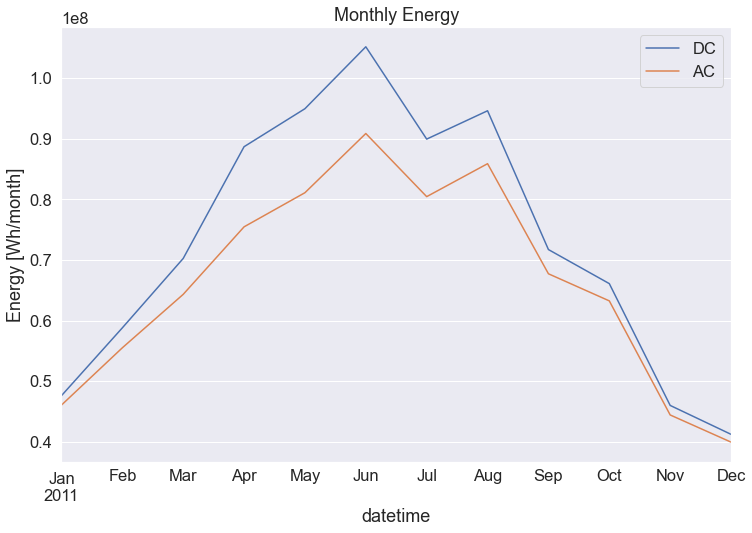

In [66]:
# the goods
earrmpp_5inst = 5/60*dc_out_5inst
egrid_5inst = 5/60*ac_out_5inst
ax = earrmpp_5inst.resample('M').sum().plot(label='DC', title='Monthly Energy')
egrid_5inst.resample('M').sum().plot(ax=ax, label='AC')
plt.ylabel('Energy [Wh/month]')
plt.legend()

In [67]:
print(f'5-minute instant annual DC & AC energy: {earrmpp_5inst.sum()/1e6, egrid_5inst.sum()/1e6} MWh')

5-minute instant annual DC & AC energy: (875.1536303034358, 795.1141584558512) MWh


## 15-minute instances

In [68]:
dc_out_15inst, ac_out_15inst, _ = calc_power(df=weather15inst, pvmodel=pvmodel_bon)

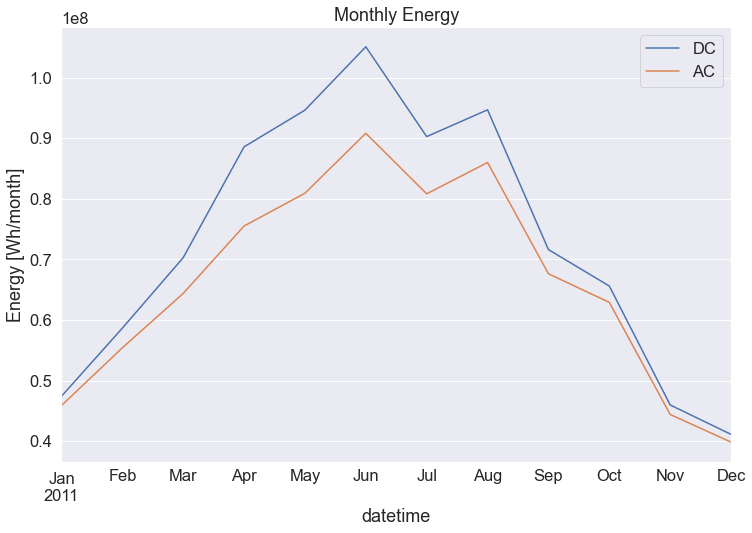

In [69]:
# the goods
earrmpp_15inst = 15/60*dc_out_15inst
egrid_15inst = 15/60*ac_out_15inst
ax = earrmpp_15inst.resample('M').sum().plot(label='DC', title='Monthly Energy')
egrid_15inst.resample('M').sum().plot(ax=ax, label='AC')
plt.ylabel('Energy [Wh/month]')
plt.legend()

In [70]:
print(f'15-minute instant annual DC & AC energy: {earrmpp_15inst.sum()/1e6, egrid_15inst.sum()/1e6} MWh')

15-minute instant annual DC & AC energy: (874.0310764675339, 794.6397198583176) MWh


## 30-minute instances

In [71]:
dc_out_30inst, ac_out_30inst, _ = calc_power(df=weather30inst, pvmodel=pvmodel_bon)

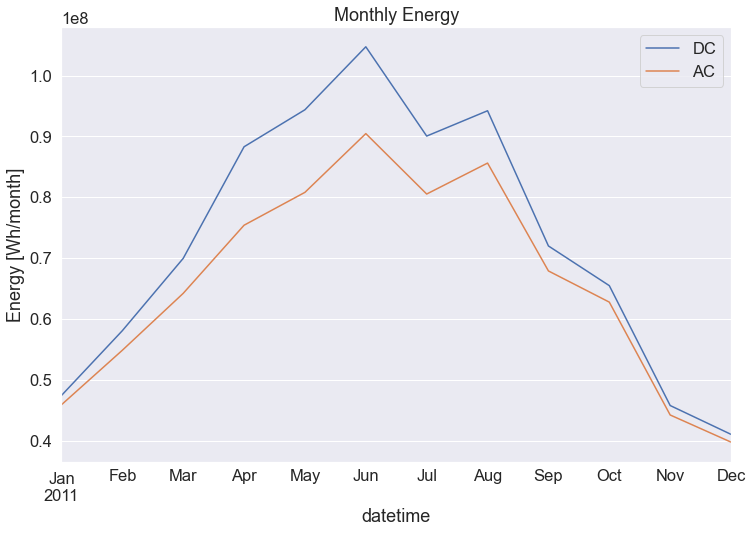

In [72]:
# the goods
earrmpp_30inst = 30/60*dc_out_30inst
egrid_30inst = 30/60*ac_out_30inst
ax = earrmpp_30inst.resample('M').sum().plot(label='DC', title='Monthly Energy')
egrid_30inst.resample('M').sum().plot(ax=ax, label='AC')
plt.ylabel('Energy [Wh/month]')
plt.legend()

In [73]:
print(f'30-minute instant annual DC & AC energy: {earrmpp_30inst.sum()/1e6, egrid_30inst.sum()/1e6} MWh')

30-minute instant annual DC & AC energy: (871.5069202017584, 792.5384300201265) MWh


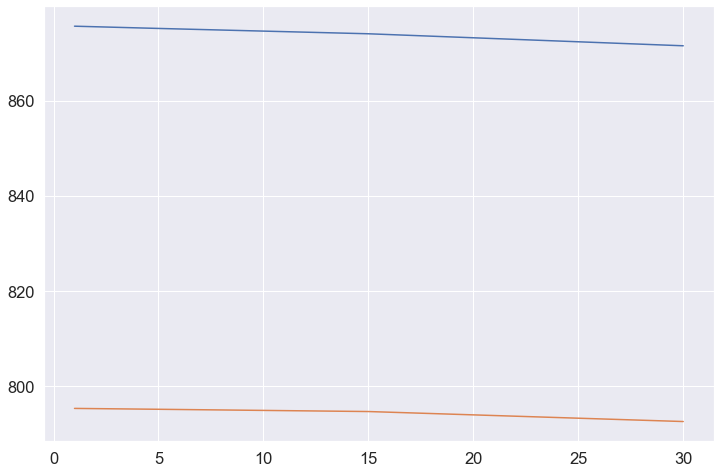

In [74]:
plt.plot(
    [1, 5, 15, 30],
    [(EARRMPP.sum()/1e6, EGRID.sum()/1e6),
     (earrmpp_5inst.sum()/1e6, egrid_5inst.sum()/1e6),
     (earrmpp_15inst.sum()/1e6, egrid_15inst.sum()/1e6),
     (earrmpp_30inst.sum()/1e6, egrid_30inst.sum()/1e6)])

## Automate
Run all the cases in a loop
1. instantaneous
2. satellite simulated
3. time-average

In [75]:
# loop over all instantaneous weather datasets
weather_inst = {
    1: weather, 5: weather5inst, 15: weather15inst, 30: weather30inst,
    60: weather60inst}
dc_out_inst = dict.fromkeys(weather_inst)
ac_out_inst = dict.fromkeys(weather_inst)
earrmpp_inst = dict.fromkeys(weather_inst)
egrid_inst = dict.fromkeys(weather_inst)
annual_energy_inst = dict.fromkeys(weather_inst)
for t, w in weather_inst.items():
    dc_out_inst[t], ac_out_inst[t], _ = calc_power(df=w, pvmodel=pvmodel_bon)
    earrmpp_inst[t] = t/60*dc_out_inst[t]
    egrid_inst[t] = t/60*ac_out_inst[t]
    annual_energy_inst[t] = {
        'EArrMPP': earrmpp_inst[t].sum()/1e6, 'Egrid': egrid_inst[t].sum()/1e6}

,EArrMPP,Egrid
1,875.625451,795.296363
5,875.153630,795.114158
15,874.031076,794.639720
30,871.506920,792.538430
60,861.387493,782.530199


<AxesSubplot:>

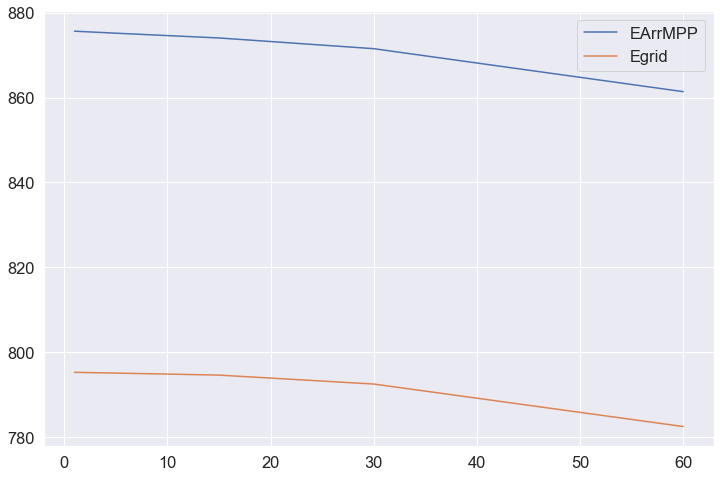

In [76]:
annual_energy_inst_df = pd.DataFrame(annual_energy_inst).T
display(annual_energy_inst_df)
annual_energy_inst_df.plot()

In [77]:
# loop over all instantaneous weather datasets time-averaged to hourly
weather_60min = {
    1: weather60min, 5: weather5inst60min, 15: weather15inst60min,
    30: weather30inst60min, 60: weather60inst}
dc_out_60min = dict.fromkeys(weather_60min)
ac_out_60min = dict.fromkeys(weather_60min)
earrmpp_60min = dict.fromkeys(weather_60min)
egrid_60min = dict.fromkeys(weather_60min)
annual_energy_60min = dict.fromkeys(weather_60min)
for t, w in weather_60min.items():
    dc_out_60min[t], ac_out_60min[t], _ = calc_power(df=w, pvmodel=pvmodel_bon)
    earrmpp_60min[t] = dc_out_60min[t]
    egrid_60min[t] = ac_out_60min[t]
    annual_energy_60min[t] = {
        'EArrMPP': earrmpp_60min[t].sum()/1e6,
        'Egrid': egrid_60min[t].sum()/1e6}

,EArrMPP,Egrid
1,874.443660,801.622895
5,874.013686,801.163297
15,873.181682,799.821437
30,870.481783,795.517047
60,861.387493,782.530199


<AxesSubplot:>

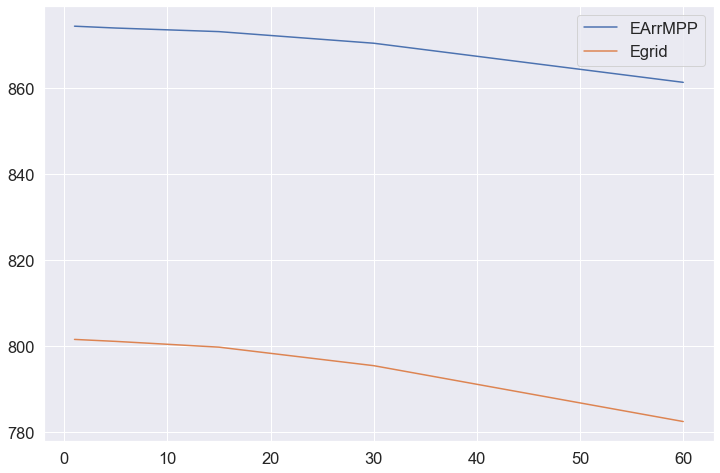

In [78]:
annual_energy_60min_df = pd.DataFrame(annual_energy_60min).T
display(annual_energy_60min_df)
annual_energy_60min_df.plot()

In [79]:
# loop over all time-averaged weather datasets
weather_avg = {
    1: weather, 5: weather5min, 15: weather15min, 30: weather30min,
    60: weather60min}
dc_out_avg = dict.fromkeys(weather_avg)
ac_out_avg = dict.fromkeys(weather_avg)
earrmpp_avg = dict.fromkeys(weather_avg)
egrid_avg = dict.fromkeys(weather_avg)
annual_energy_avg = dict.fromkeys(weather_avg)
for t, w in weather_avg.items():
    dc_out_avg[t], ac_out_avg[t], _ = calc_power(df=w, pvmodel=pvmodel_bon)
    earrmpp_avg[t] = t/60*dc_out_avg[t]
    egrid_avg[t] = t/60*ac_out_avg[t]
    annual_energy_avg[t] = {
        'EArrMPP': earrmpp_avg[t].sum()/1e6, 'Egrid': egrid_avg[t].sum()/1e6}

,EArrMPP,Egrid
1,875.625451,795.296363
5,875.930604,797.502512
15,876.292090,799.968287
30,876.200868,801.345944
60,874.443660,801.622895


<AxesSubplot:>

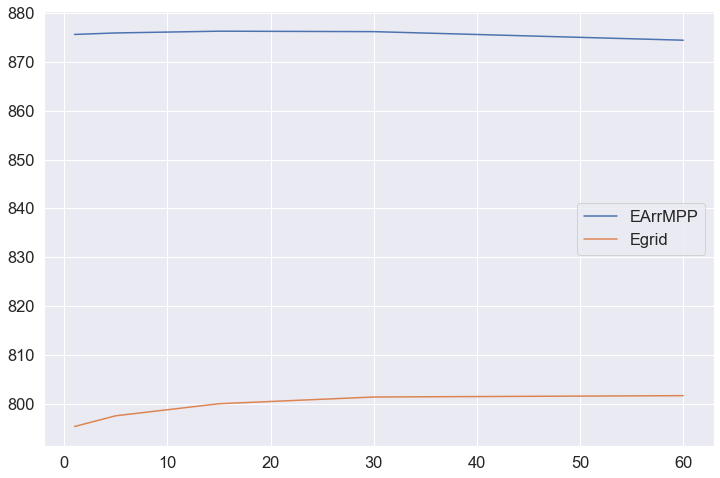

In [80]:
annual_energy_avg_df = pd.DataFrame(annual_energy_avg).T
display(annual_energy_avg_df)
annual_energy_avg_df.plot()

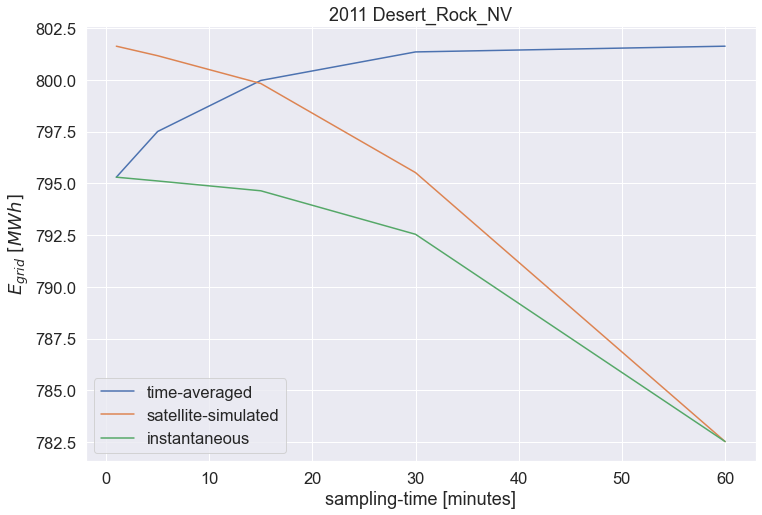

In [81]:
ax = annual_energy_avg_df['Egrid'].plot(label='time-averaged')
annual_energy_60min_df['Egrid'].plot(ax=ax, label='satellite-simulated')
annual_energy_inst_df['Egrid'].plot(ax=ax, label='instantaneous')
plt.xlabel('sampling-time [minutes]')
plt.ylabel('$E_{grid}\ [MWh]$')
plt.title(f'{YEAR} {weather_dir}')
plt.legend()
plt.savefig(f'{CODENAME}{YEAR}.png');

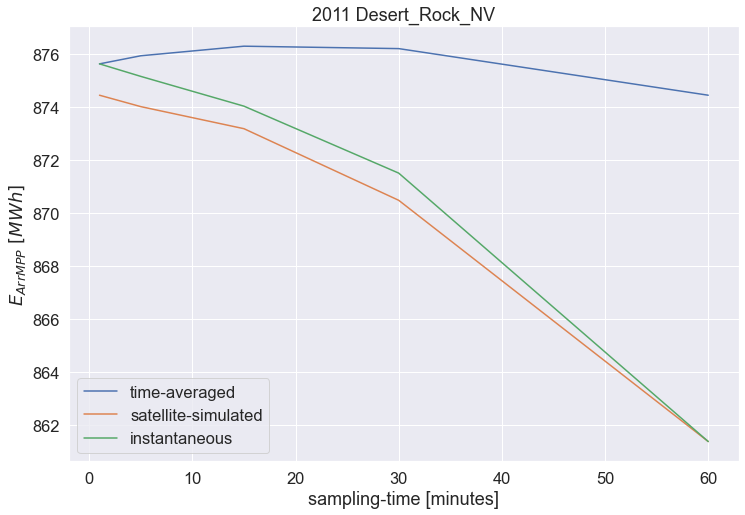

In [82]:
ax = annual_energy_avg_df['EArrMPP'].plot(label='time-averaged')
annual_energy_60min_df['EArrMPP'].plot(ax=ax, label='satellite-simulated')
annual_energy_inst_df['EArrMPP'].plot(ax=ax, label='instantaneous')
plt.xlabel('sampling-time [minutes]')
plt.ylabel('$E_{ArrMPP}\ [MWh]$')
plt.title(f'{YEAR} {weather_dir}')
plt.legend()